## Download 10x scATAC dataset

In [24]:
!wget -O ./data/fragments_atac_1.2.0_5k_pbmc.tsv.gz \
  https://cf.10xgenomics.com/samples/cell-atac/1.2.0/atac_v1_pbmc_5k/atac_v1_pbmc_5k_fragments.tsv.gz
!wget -O ./data/fragments_atac_1.2.0_5k_pbmc.tsv.gz.tbi \
  https://cf.10xgenomics.com/samples/cell-atac/1.2.0/atac_v1_pbmc_5k/atac_v1_pbmc_5k_fragments.tsv.gz.tbi
!wget -O ./data/peaks_atac_1.2.0_5k_pbmc.tsv \
  https://cf.10xgenomics.com/samples/cell-atac/1.2.0/atac_v1_pbmc_5k/atac_v1_pbmc_5k_peak_annotation.tsv

--2020-08-04 19:17:34--  https://cf.10xgenomics.com/samples/cell-atac/1.2.0/atac_v1_pbmc_5k/atac_v1_pbmc_5k_peak_annotation.tsv
Resolving cf.10xgenomics.com (cf.10xgenomics.com)... 104.18.1.173, 104.18.0.173, 2606:4700::6812:ad, ...
Connecting to cf.10xgenomics.com (cf.10xgenomics.com)|104.18.1.173|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3846022 (3.7M) [text/tab-separated-values]
Saving to: ‘./data/peaks_atac_1.2.0_5k_pbmc.tsv’

./data/peaks_atac_1 100%[===================>]   3.67M  10.6MB/s    in 0.3s    

2020-08-04 19:17:34 (10.6 MB/s) - ‘./data/peaks_atac_1.2.0_5k_pbmc.tsv’ saved [3846022/3846022]



In [2]:
!wget -O ./data/clusters_atac_1.2.0_5k_pbmc.tar.gz \
  https://cf.10xgenomics.com/samples/cell-atac/1.2.0/atac_v1_pbmc_5k/atac_v1_pbmc_5k_analysis.tar.gz

--2020-08-04 18:48:58--  https://cf.10xgenomics.com/samples/cell-atac/1.2.0/atac_v1_pbmc_5k/atac_v1_pbmc_5k_analysis.tar.gz
Resolving cf.10xgenomics.com (cf.10xgenomics.com)... 104.18.1.173, 104.18.0.173, 2606:4700::6812:1ad, ...
Connecting to cf.10xgenomics.com (cf.10xgenomics.com)|104.18.1.173|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 182286803 (174M) [application/x-tar]
Saving to: ‘./data/clusters_atac_1.2.0_5k_pbmc.tar.gz’

./data/clusters_ata 100%[===================>] 173.84M  8.43MB/s    in 14s     

2020-08-04 18:49:14 (12.1 MB/s) - ‘./data/clusters_atac_1.2.0_5k_pbmc.tar.gz’ saved [182286803/182286803]



In [12]:
cluster_file = './data/5k_pbmc/analysis/clustering/graphclust/clusters.csv'
fragment_file = './data/5k_pbmc/fragments_atac_1.2.0_5k_pbmc.tsv.gz'

In [10]:
%%time
import gzip
barcode_count = {}
with gzip.open(fragment_file, 'rt') as f:
    for line in f:
        line = line.strip().split('\t')
        if line[-2] not in barcode_count:
            barcode_count[line[-2]] = 0
        barcode_count[line[-2]] += int(line[-1])

CPU times: user 2min 50s, sys: 0 ns, total: 2min 50s
Wall time: 6min 42s


In [15]:
%%time
clusters = open(cluster_file).readlines()[1:]
with open('./data/5k_pbmc/grouping_table.txt', 'w') as f:
    f.write('cell\tgroup\ttotal_reads\n')
    for line in clusters:
        cell, group = line.strip().split(',')
        read_count = barcode_count[cell]
        f.write(f'{cell}\t{group}\t{read_count}\n')

CPU times: user 10.9 ms, sys: 0 ns, total: 10.9 ms
Wall time: 2.18 s


## Get coverages for each cluster in specific region

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, '..')
import coverage_gpu

In [14]:
%%time
FRAGMENTS_FILE = './data/5k_pbmc/fragments_atac_1.2.0_5k_pbmc.tsv.gz'
GROUPING_FILE = './data/5k_pbmc/grouping_table.txt'

df, chrom_map = coverage_gpu.initialize(FRAGMENTS_FILE)
print(len(df))


intervals_cudf = coverage_gpu.get_coverages(df, chrom_map, 'chr1', 900000, 1000000,
                                            GROUPING_FILE)

intervals_cudf = coverage_gpu.get_coverages(df, chrom_map, 'chr1', 700000, 800000,
                                            GROUPING_FILE)

1636
CPU times: user 212 ms, sys: 2.2 s, total: 2.41 s
Wall time: 2.41 s


In [29]:
%%time
from get_coverages import tabix_query
tabix_query('./data/5k_pbmc/fragments_atac_1.2.0_5k_pbmc.tsv.gz', 'chr1', 700000, 720000)

CPU times: user 0 ns, sys: 4.99 ms, total: 4.99 ms
Wall time: 2.18 s


<generator object tabix_query at 0x7f81a55b0050>

In [15]:
df

,chrom,start,end,cell,chrom_hashed,row_num
0,chr1,10066,10198,CTCTCAGTCCGGGCAT-1,-1293144521,0
1,chr1,10071,10279,CAGGGCTTCTTTCGAT-1,-1293144521,1
2,chr1,10073,10186,GCCTAGGCAGTGCTCG-1,-1293144521,2
3,chr1,10073,10333,ACTAACGCAGATGGCA-1,-1293144521,3
4,chr1,10085,10284,ATTTGTCCAATGCCAT-1,-1293144521,4
...,...,...,...,...,...,...
1631,chr1,713982,714133,GACTAGTCACGATATC-1,-1293144521,1631
1632,chr1,713982,714142,GCATTCCAGTAGTTCC-1,-1293144521,1632
1633,chr1,713982,714144,TGCACCTCATAAAGTG-1,-1293144521,1633
1634,chr1,713982,714152,CCTCCCTAGGGAGATA-1,-1293144521,1634


In [16]:
print(len(intervals_cudf))
intervals_cudf.head()

164547


,index,start,end,chrom,cell,chrom_hashed,group,total_reads,cells_in_cluster,value,diff,inversed_reads,sum_inversed_reads,normalized_total
0,108343,700367,700368,chr1,CCTTAATCAACTACTG-1,-1293144521,3,19244,532,1,181,0.000052,0.000052,9.767716e-08
1,108344,700368,700369,chr1,CCTTAATCAACTACTG-1,-1293144521,3,19244,532,1,181,0.000052,0.000052,9.767716e-08
2,108345,700369,700370,chr1,CCTTAATCAACTACTG-1,-1293144521,3,19244,532,1,181,0.000052,0.000052,9.767716e-08
3,108346,700370,700371,chr1,CCTTAATCAACTACTG-1,-1293144521,3,19244,532,1,181,0.000052,0.000052,9.767716e-08
4,108347,700371,700372,chr1,CCTTAATCAACTACTG-1,-1293144521,3,19244,532,1,181,0.000052,0.000052,9.767716e-08


In [17]:
%%time
keep_columns = ['start', 'end', 'chrom', 'normalized_total', 'group']
intervals = intervals_cudf.to_pandas()[keep_columns]
intervals.rename(columns={'normalized_total' : 'score'}, inplace=True)
intervals.head()

CPU times: user 59 ms, sys: 21.6 ms, total: 80.6 ms
Wall time: 79.1 ms


,start,end,chrom,score,group
0,700367,700368,chr1,9.767716e-08,3
1,700368,700369,chr1,9.767716e-08,3
2,700369,700370,chr1,9.767716e-08,3
3,700370,700371,chr1,9.767716e-08,3
4,700371,700372,chr1,9.767716e-08,3


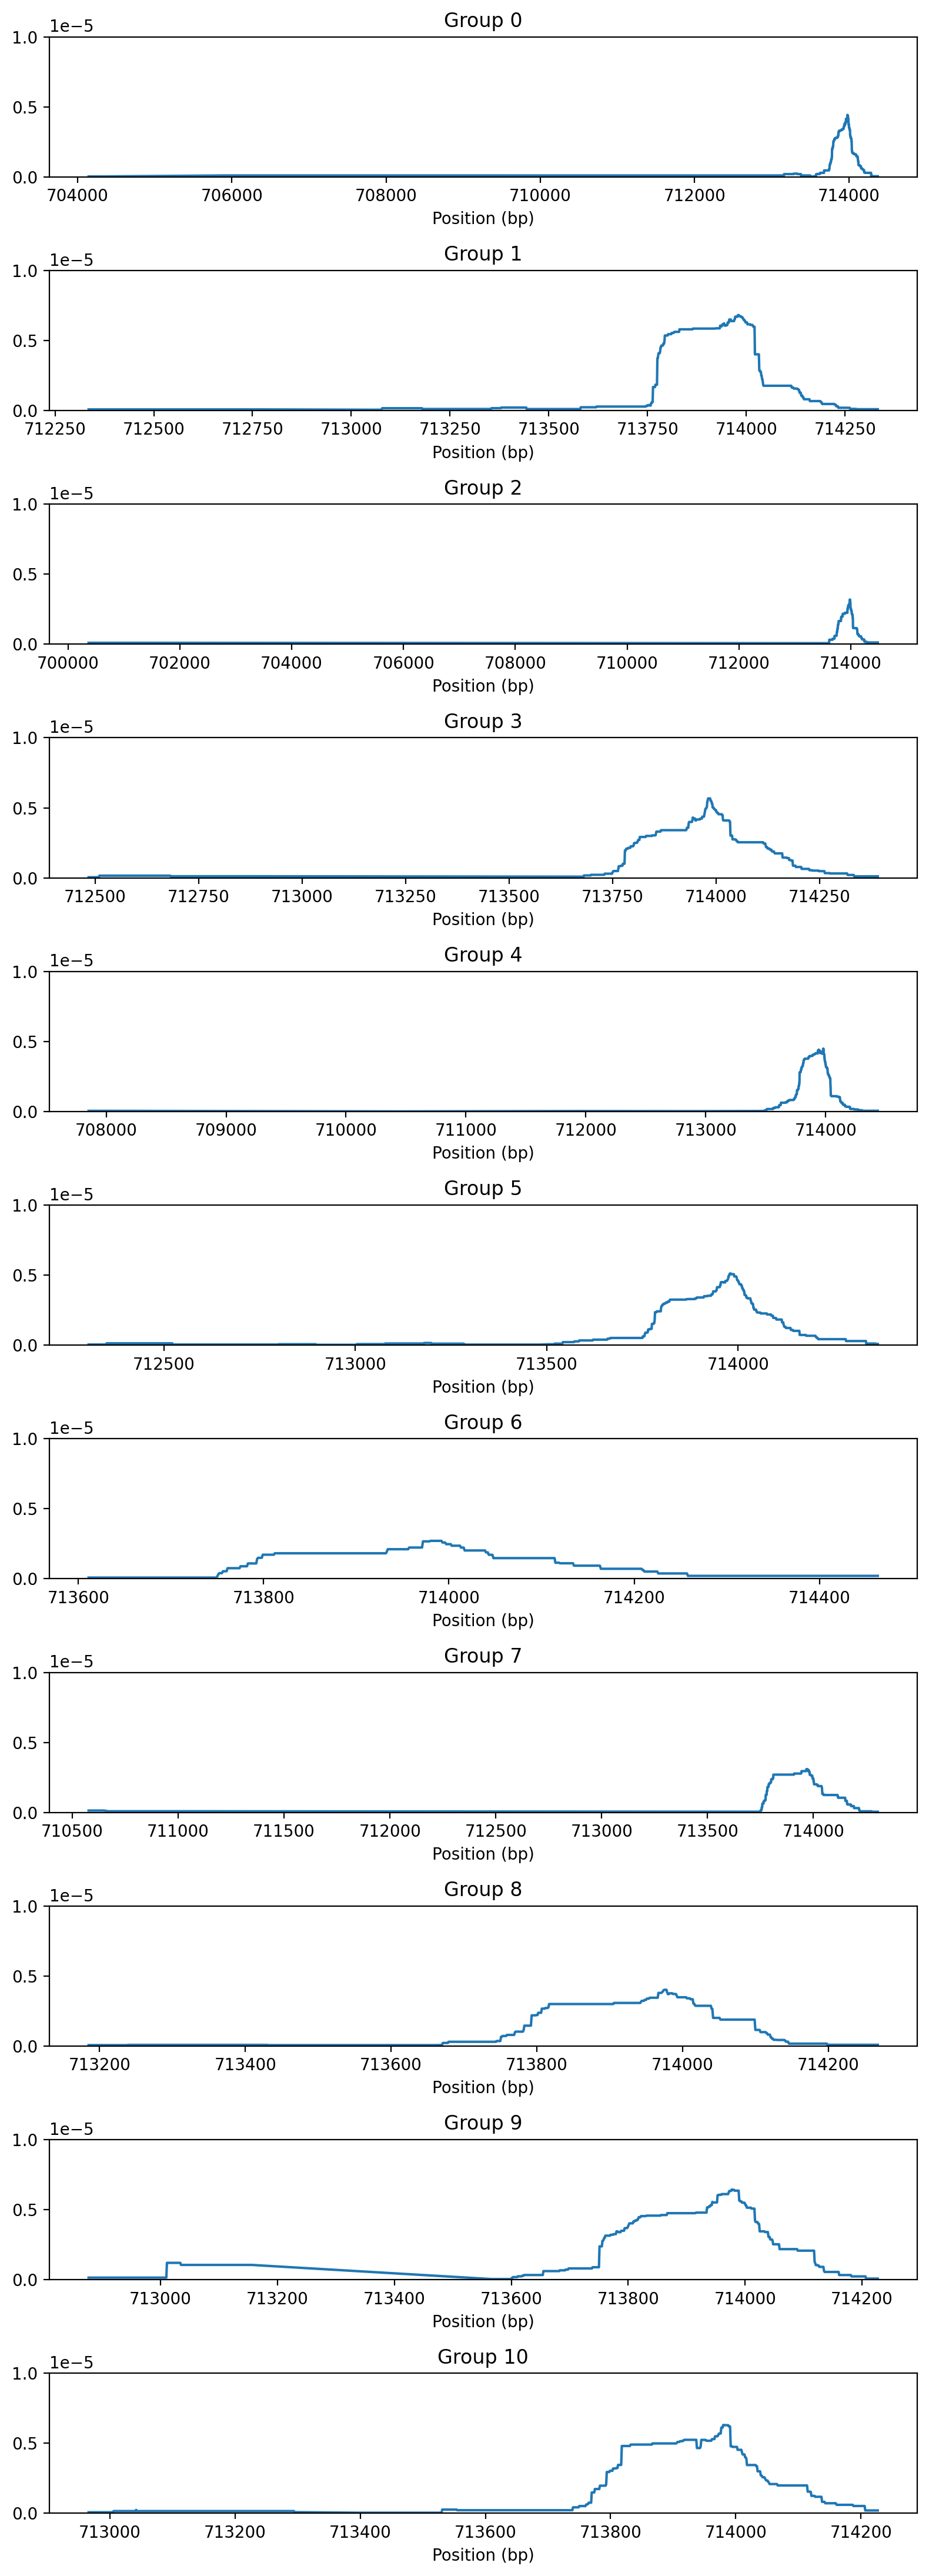

In [31]:
%%time
groups = np.unique(intervals['group'])
n_groups = len(groups)

fig, axs = plt.subplots(nrows = n_groups, ncols = 1, figsize = (8, 2*n_groups), dpi=200)

for (i, group) in enumerate(groups):
    df_group = intervals.loc[intervals['group'] == group]
    axs[i].plot(df_group['start'], df_group['score'])
    axs[i].set_title(f'Group {i}')
    axs[i].set_ylim([0.0, 1e-5])
    axs[i].set_xlabel('Position (bp)')

plt.tight_layout()
plt.show()

In [18]:
%%time
intervals.to_csv('./data/5k_pbmc/sample_coverage.tsv', sep='\t')

CPU times: user 1.07 s, sys: 0 ns, total: 1.07 s
Wall time: 2.14 s


## AtacWorks inference on bp-resolution intervals

Run below cell once, in order to download weights for 50kb resolution AtacWorks model trained on immune cells.

In [ ]:
!mkdir models
!wget -P models https://api.ngc.nvidia.com/v2/models/nvidia/atac_dsc_atac_lowcellcount_1m_48m_50_2400/versions/0.3/files/models/model.pth.tar

In [1]:
%%time
import pandas as pd
import torch
from atacworks.dl4atac.layers import ZeroSamePad1d, Activation, ConvAct1d, ResBlock
from atacworks.dl4atac.models.models import DenoisingResNet
from atacworks.dl4atac.models.model_utils import load_model

In [2]:
intervals = pd.read_csv('./data/5k_pbmc/sample_coverage.tsv', sep='\t', index_col=0)
intervals.head()

,start,end,chrom,score,group
0,700367,700368,chr1,9.767716e-08,3
1,700368,700369,chr1,9.767716e-08,3
2,700369,700370,chr1,9.767716e-08,3
3,700370,700371,chr1,9.767716e-08,3
4,700371,700372,chr1,9.767716e-08,3


In [14]:
%%time
model = DenoisingResNet(interval_size=50000, kernel_size=51, kernel_size_class=51)
weights_path = './models/model.pth.tar'
gpu = 0
model = load_model(model, weights_path=weights_path, rank=gpu)
model = model.cuda(gpu)

Loading model weights from ./models/model.pth.tar...
Finished loading.
CPU times: user 20.8 ms, sys: 0 ns, total: 20.8 ms
Wall time: 20.2 ms


In [39]:
%%time
interval_start = 700000
groups = sorted(np.unique(intervals['group']))
x = torch.zeros((len(groups), 50000))

for (i, group) in enumerate(groups):
    df_group = intervals.loc[intervals['group'] == group]
    coords = list(df_group['start'] - interval_start)
    values = torch.Tensor(df_group['score'].values)
    x[i][coords] = values
    nonzero = (x[i] != 0).sum()
    print(f"Group {group} has {nonzero} nonzero basepairs in interval")

Group 0 has 1879 nonzero basepairs in interval
Group 1 has 1775 nonzero basepairs in interval
Group 2 has 1155 nonzero basepairs in interval
Group 3 has 1162 nonzero basepairs in interval
Group 4 has 1626 nonzero basepairs in interval
Group 5 has 2021 nonzero basepairs in interval
Group 6 has 853 nonzero basepairs in interval
Group 7 has 1349 nonzero basepairs in interval
Group 8 has 1078 nonzero basepairs in interval
Group 9 has 943 nonzero basepairs in interval
Group 10 has 1176 nonzero basepairs in interval


In [40]:
%%time
x = x.unsqueeze(1)
x = x.cuda(gpu, non_blocking=True)
pred = model(x)

CPU times: user 29.3 ms, sys: 0 ns, total: 29.3 ms
Wall time: 31.9 ms


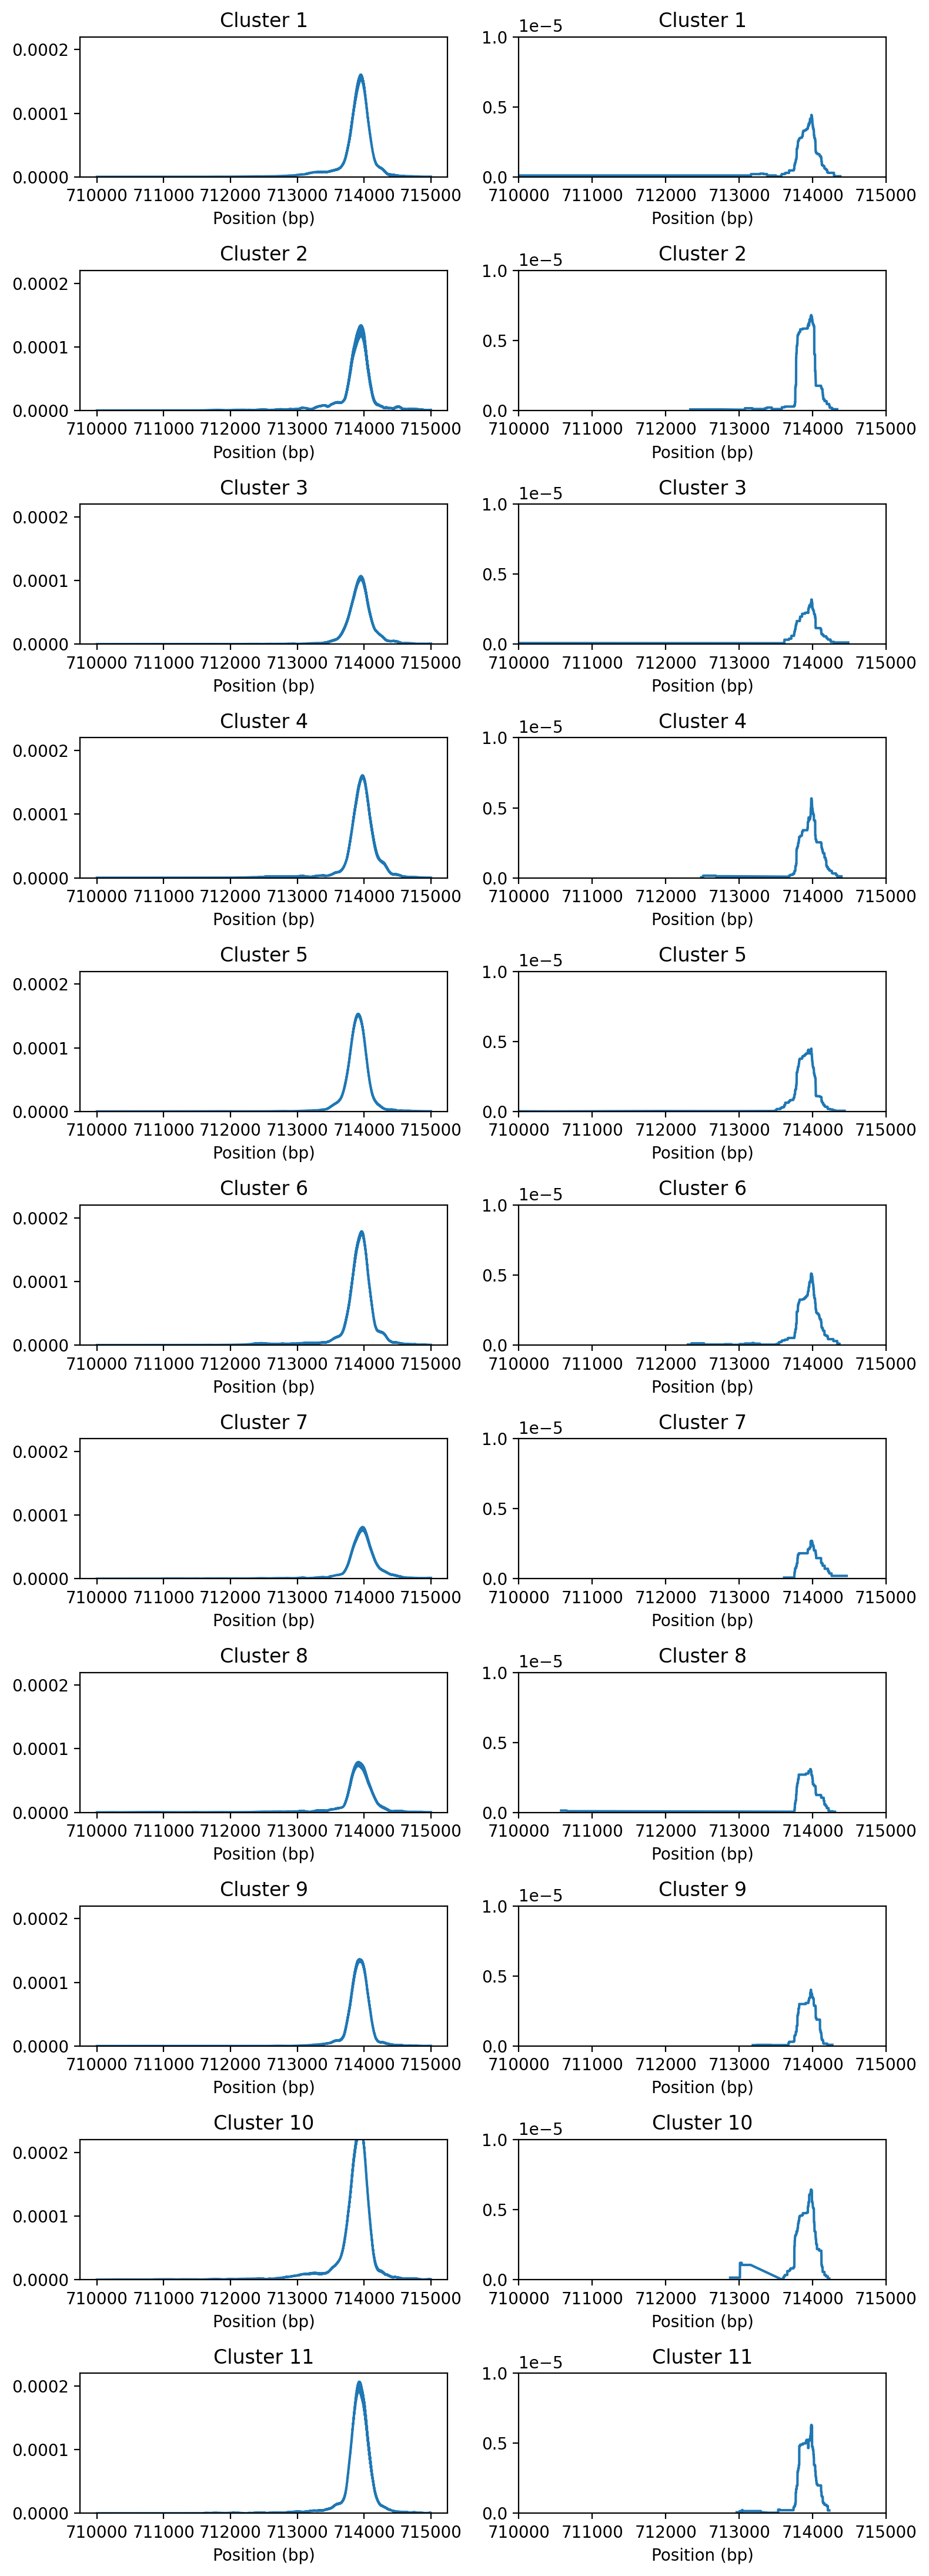

CPU times: user 5.18 s, sys: 637 ms, total: 5.82 s
Wall time: 10.4 s


In [50]:
%%time
import matplotlib.pyplot as plt

fig, axs = plt.subplots(nrows = len(groups), ncols = 2, figsize = (8, 2*len(groups)), dpi=200)

plot_subrange = [10000, 15000]
for (i, group) in enumerate(groups):
    coords = interval_start + np.arange(plot_subrange[0], plot_subrange[1])
    vals = pred[0][i][plot_subrange[0] : plot_subrange[1]].cpu().detach().numpy()
    axs[i][0].plot(coords, vals)
    axs[i][0].set_title(f'Cluster {group}')
    axs[i][0].set_ylim([0.0, 2.2e-4])
    axs[i][0].set_xlabel('Position (bp)')
    
    df_group = intervals.loc[intervals['group'] == group]
    axs[i][1].plot(df_group['start'], df_group['score'])
    axs[i][1].set_title(f'Cluster {group}')
    axs[i][1].set_xlim([interval_start + plot_subrange[0], interval_start + plot_subrange[1]])
    axs[i][1].set_ylim([0.0, 1e-5])
    axs[i][1].set_xlabel('Position (bp)')
    
plt.tight_layout()
plt.show()